# Implémentation du réseau de neurones et expérimentation

In [1]:
import numpy as np
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 0. Implémentation de fonctions utiles
Calcul numériquement stable du softmax

In [2]:
def softmax_vector(x):
    '''
    x:  is a data vector.
    returns: the result of the softmax function applied to the data vector.
    '''
    max_comp = np.amax(x)
    normalized  = x - max_comp
    
    exponential = np.exp(normalized)
    
    return exponential/np.sum(exponential)

In [3]:
def softmax(X):
    '''
    X: matrix that holds the data, every row is a data vector.
    returns: matrix where every row is the result of the softmax function applied to the corresponding data vector.
    '''
    
    max_comp = np.amax(X, axis=1)
    normalized  = X - max_comp.reshape(X.shape[0], 1)
    
    exponential = np.exp(normalized)
    
    return exponential/np.sum(exponential, axis=1).reshape(X.shape[0], 1)

Fonction utilitaire pour calculer relu($x$)

In [4]:
def relu(x):
    return np.maximum(x, np.zeros(x.shape))

def onehot(m, y):
    return np.eye(m)[y]

def onehot_matrix(m, targets):
    """
    Returns: onehot matrix where every column is a onehot vector of the coressponding target
    """
    eye = np.eye(m)
    onehot_matrix = np.zeros((m,len(targets)))
    
    for i, y in enumerate(targets):
        onehot_matrix[:,i] = eye[y]
        
    return onehot_matrix

## 1. Calcul du gradient sur un exemple

Implementation de fprop et bprop pour calculer le gradient sur un exemple

In [5]:
class NeuralNet_basic:
    
    def __init__(self, n_input, n_hidden, n_out):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, x):
        '''Computes activations for every layer'''
        self.ha = self.W1.dot(x) + self.b1
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2
        self.os = softmax_vector(self.oa)
            
    def bprop(self, x, y):
        '''Computes the gradients, must be executed after fprop'''
                      
        grad_oa = self.os - onehot(self.n_o, y)
        grad_b2 = grad_oa
        grad_W2 = np.outer(grad_oa, self.hs)
        grad_hs = self.W2.T.dot(grad_oa)
        grad_ha = grad_hs * (self.ha > 0)
        grad_W1 = np.outer(grad_ha, x)
        grad_b1 = grad_ha
        
        return grad_W1, grad_W2, grad_b1, grad_b2

## 2. Vérification du gradient par différences finies

On va maintenant vérifier que le gradient calculé est juste. Pour cela on va calculer une approximation du gradient en utilisant la méthode de la différence finie.

Pour chaque composante de w1, on va:
 1. calculer la valeur de la fonction objectif $L$
 2. ajouter une petite valeur $\epsilon$ à la composante
 3. recalculer la valeur de la fonction objectif $L'$
 4. remettre à l'ancienne valeur la composante (c'est à dire soustraire $\epsilon$)

Le gradient par différences finies sera dans ce cas donné par:
$\Big( \frac{\partial L}{\partial W_{1}} \Big)_{ij} = \frac{1}{\epsilon} (L' - L)$

In [6]:
def compute_loss(x, y, W1, W2, b1, b2):
    ha = W1.dot(x) + b1
    hs = relu(ha)
    oa = W2.dot(hs) + b2
    os = softmax_vector(oa)
    
    return -np.log(os[y])

Fonction pour calculer le gradient par differences finies

In [7]:
def finite_diff(x, y, neural_net, eps=1e-5):
    
    # params
    W1 = neural_net.W1
    W2 = neural_net.W2
    b1 = neural_net.b1
    b2 = neural_net.b2
    
    # gradients
    grad_w1_diff = np.zeros(W1.shape)
    grad_w2_diff = np.zeros(W2.shape)
    grad_b1_diff = np.zeros(b1.shape)
    grad_b2_diff = np.zeros(b2.shape)
    
    neural_net.fprop(x)
    loss = compute_loss(x, y, W1, W2, b1, b2)
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1[i,j] = W1[i,j] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_w1_diff[i, j] = (loss_prime - loss) / epsilon
            W1[i,j] = W1[i,j] - eps
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2[i,j] = W2[i,j] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_w2_diff[i, j] = (loss_prime - loss) / epsilon
            W2[i,j] = W2[i,j] - eps
    for i in range(b1.shape[0]):
            b1[i] = b1[i] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_b1_diff[i] = (loss_prime - loss) / epsilon
            b1[i] = b1[i] - eps
    for i in range(b1.shape[0]):
            b2[i] = b2[i] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_b2_diff[i] = (loss_prime - loss) / epsilon
            b2[i] = b2[i] - eps
            
    return grad_w1_diff, grad_w2_diff, grad_b1_diff, grad_b2_diff
    

Affichage de vérification du gradient par différence finie

In [8]:
data = np.loadtxt(open('2moons.txt','r'))

In [9]:
nn = NeuralNet_basic(2, 2, 2)
x = data[0,:-1]
y = data[0,-1]
epsilon = 1e-5

# gradients par différence finie
grad_w1_diff, grad_w2_diff, grad_b1_diff, grad_b2_diff = finite_diff(x, y, nn, epsilon)

# gradients par implémentation dans classe neural_net
grad_W1, grad_W2, grad_b1, grad_b2 = nn.bprop(x,y)

# affichage de la différence
print('Différence entre les deux gradients pour W1, W2, b1, b2:')
print(grad_W1 / grad_w1_diff)
print(grad_W2 / grad_w2_diff)
print(grad_b1 / grad_b1_diff)
print(grad_b2 / grad_b2_diff)

Différence entre les deux gradients pour W1, W2, b1, b2:
[[ 1.00000019  0.99999906]
 [        nan         nan]]
[[ 1.00000091         nan]
 [ 0.99999909         nan]]
[ 1.00000052         nan]
[ 1.00000259  0.99999741]


On remarque q'effectivement les ratio sont entre 0.99 et 1.01. Les NaN apparaissent lorsque les deux paramètres (ceux calculé avec la différence finie et le gradient) sont égales à zéro.

In [10]:
print("Gradient de W1 par difference finie:")
print(grad_w1_diff)
print("Gradient de W1:")
print(grad_W1)

print("Gradient de W2 par difference finie:")
print(grad_w2_diff)
print("Gradient de W2:")
print(grad_W2)

Gradient de W1 par difference finie:
[[-0.03556993  0.17480137]
 [ 0.          0.        ]]
Gradient de W1:
[[-0.03556994  0.17480121]
 [ 0.         -0.        ]]
Gradient de W2 par difference finie:
[[-0.16879107  0.        ]
 [ 0.16879138  0.        ]]
Gradient de W2:
[[-0.16879122 -0.        ]
 [ 0.16879122  0.        ]]


## 3. Ajout de hyperparamètre de taille de lot K
La fonction bprop est modifiée pour calculer le gradient sur un batch d'exemple. La fonction train est également ajoutée.

In [11]:
class NeuralNet_loop:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K = 1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.K = K
        self.lambdas = lambdas
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        np.random.seed(123)
        
        # Initialize the parameters
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, x):
        '''Computes activations for every layer'''
        ha = self.W1.dot(x) + self.b1
        hs = relu(ha)
        oa = self.W2.dot(hs) + self.b2
        os = softmax_vector(oa)
        return ha, hs, oa, os
            
    def bprop(self, X, Y):
        '''Computes the gradients over all examples in (X,Y) with loop'''
        grad_W1_mean = np.zeros((self.n_h, self.n_in))
        grad_W2_mean = np.zeros((self.n_o, self.n_h))
        grad_b1_mean = np.zeros(self.n_h)
        grad_b2_mean = np.zeros(self.n_o)
        
        n = X.shape[0]
        loss = 0.
        
        for i in range(n):
            
            ha, hs, oa, os = self.fprop(X[i,:])
            loss += -np.log(os[Y[i]])
            
            grad_oa = os - onehot(self.n_o, Y[i])
            grad_b2 = grad_oa
            grad_W2 = np.outer(grad_oa, hs)
            grad_hs = self.W2.T.dot(grad_oa)
            grad_ha = grad_hs * (ha > 0)
            grad_W1 = np.outer(grad_ha, X[i,:])
            grad_b1 = grad_ha
            
            grad_W1_mean = grad_W1_mean + grad_W1 / n
            grad_W2_mean = grad_W2_mean + grad_W2 / n
            grad_b1_mean = grad_b1_mean + grad_b1 / n
            grad_b2_mean = grad_b2_mean + grad_b2 / n
        
        return grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean, loss 
    
    def compute_loss(self, x, y):
        _, _, _, os = self.fprop(x)
        return -np.log(self.os[y])
    
    def train(self, train_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        # Initialize batch start and end indices
        
        for i in range(max_iter):
            loss = 0.
            for j in range(0,train_data.shape[0],self.K):
                batch = train_data[j:j+self.K]
                
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean, bloss = self.bprop(batch[:,:-1], batch[:,-1]) 
                loss += bloss
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                
            #if i%100 == 0:
                #print('The loss after epoque ', i, ' is ', loss / train_data.shape[0])
                    
    def compute_predictions(self, test_data):

        pred = np.empty((test_data.shape[0],self.n_o))

        for i in range(test_data.shape[0]):
            _, _, _, os = self.fprop(test_data[i,:])
            pred[i,:] = os

        return pred


## 4. Vérification du gradient par différence finie

Affichage de vérification du gradient pour un lot de 10 exemples

In [12]:
lambdas = np.array([[0, 0],
       [0, 0]])
nn = NeuralNet_loop(2, 2, 2, lambdas)
X = data[0:10,:-1]
Y = data[0:10,-1]

# params
W1 = nn.W1
W2 = nn.W2
b1 = nn.b1
b2 = nn.b2

# gradients par différence finie
grad_w1_diff = np.zeros(W1.shape)
grad_w2_diff = np.zeros(W2.shape)
grad_b1_diff = np.zeros(b1.shape)
grad_b2_diff = np.zeros(b2.shape)

for i in range(X.shape[0]):
    grad_w1, grad_w2, grad_b1, grad_b2 = finite_diff(X[i,:], Y[i], nn, epsilon)
    grad_w1_diff += grad_w1 / X.shape[0]
    grad_w2_diff += grad_w2 / X.shape[0]
    grad_b1_diff += grad_b1 / X.shape[0]
    grad_b2_diff += grad_b2 / X.shape[0]
    
# gradients par implémentation dans classe neural_net    
grad_W1, grad_W2, grad_b1, grad_b2, _ = nn.bprop(X,Y)

# affichage de la différence
print('Différence entre les deux gradients pour W1, W2, b1, b2:')

print(grad_W1 / grad_w1_diff)
print(grad_W2 / grad_w2_diff)
print(grad_b1 / grad_b1_diff)
print(grad_b2 / grad_b2_diff)

Différence entre les deux gradients pour W1, W2, b1, b2:
[[ 1.00000483  1.00000193]
 [ 0.9999974   1.00000191]]
[[ 1.00000193  0.99999863]
 [ 0.99999807  1.00000138]]
[ 0.99999848  1.00000208]
[ 0.9999829  1.0000171]


On remarque que les ration sont effectivement entre 0.99 et 1.01.

## 5. Entraînement sur 2 moons et visualisation des régions de décision

Fonction de calcul du taux d'erreur de classification

In [13]:
#Cette fonction renvoie le taux d'erreur étant donné un classifieur et un ensemble de données
def taux_erreur(classifieur, data):
    x = data[:, :-1]
    y = data[:, -1]
    data_prob = classifieur.compute_predictions(x)
    data_classe_pred = np.argmax(data_prob, axis=1)
    
    return 100. * np.mean(data_classe_pred != y)

Fonction d'affichage des régions de décision 

In [14]:
# fonction plot
import pylab
def gridplot(classifieur,train,test,n_points=50):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))

    les_comptes = classifieur.compute_predictions(thegrid)
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    pylab.pcolormesh(xgrid, ygrid, classesPred.reshape((n_points, n_points)).T, alpha=.3)
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50)
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50)

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1, = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=5) 
    h2, = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=5) 
    h3, = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=5) 
    handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    pylab.legend(handles,labels)

    pylab.axis('equal')
    pylab.show()
    
## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout


Entraînement sur les données 2 moons: définition d'ensembles de train et validation

In [15]:
import random

ntrain = 2* (data.shape[0] // 3)

inds = [i for i in range(data.shape[0])]
np.random.seed(123)
np.random.shuffle(inds)

test_inds = inds[:ntrain]
validation_inds = inds[ntrain:]

#On définit l'ensemble d'entraînement et l'ensemble de validation
train_data = data[test_inds,]
validation_data = data[validation_inds,]
print(train_data.shape)
print(validation_data.shape)

#définition de la fonction frange
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

(732, 3)
(368, 3)


On teste ici différentes combinaisons d'hyperparamètres contrôlant la capacité: nombres de neurones dans couche cachées (10, 20, 100 ou 200), valeurs des lambdas (0.1, 0.001, 0.00001, 0), et nombre d'époques (50, 100, 400, 1000). Nous affichons le taux d'erreur de classification pour chaque combinaison. Pour tester ces combinaisons, on fixe le learning rate à 0.05 et la taille des lots à 100.

In [16]:
#Optimisation des paramètres de capacité: nbre couches cachées et lambdas
#lambdas = np.array([[0.1, 0.1],
#       [0.1, 0.1]])
#lambdas = np.array([[0.001, 0.001],
#       [0.001, 0.001]])
lambdas = np.array([[0.00001, 0.00001],
       [0.00001, 0.00001]])

erreurs = np.zeros([4,4])
i = 0
for C in [10, 20, 100, 200]:
    j = 0
    for epoque in [50, 100, 400, 1000]:
        nn = NeuralNet_loop(2,C,2,lambdas, 100)   
        nn.train(train_data,epoque,0.05)  
        erreurs[i,j] = taux_erreur(nn, validation_data)
        j = j + 1
    i = i + 1
print(erreurs)

KeyboardInterrupt: 

On remarque que les lambdas doivent prendre des valeurs très petites pour que l'aprentissage fonctionne: à partir de 0.1 les lambdas sont déjà trop élevés et les $W_{ij}$ appris ont des valeurs trop petites. On obtient un taux d'erreur mauvais de 51.63%. Si on baisse la valeur des lambdas à 0.001 on peut obtenir des taux d'erreur jusqu'à 1.35%, et les meilleurs résultats sont obtenus en baissant lambda à 0.00001 ou à 0. Le meilleur taux d'erreur obtenu dans ces deux cas là est 0.81%

On remarque qu'on peut obtenir des bon résultats, que ce soit avec 10, 20, 100 ou 200 neurones cachés. En revanche, plus le nombre de neurones dans la couche cachée est élevé, plus il faudra diminuer le nombre d'époques pour éviter l'overfitting.
Avec 100 ou 200 neurones, le taux d'erreur est le meilleur après 400 itérations (0.81%), ensuite il remonte à 1.08%.

Finalement, on constate que 50 ou 100 époques n'est pas suffisant pour diminuer le taux d'erreur (qui varie entre 9% et 20% selon le nombre de neurones dans la couche cachées). Nous avons besoin d'au moins 400 époques.

Dans ce qui suit, on fixe le nombre de neurones dans la couche cachée à 20, on fixe lambda à 0.00001, et on optimise les paramètres d'optimisation. Nous testons différentes valeurs de learning rate, de taille de lot, et nous réoptimisons le nombre d'époques.

In [17]:
#Optimisation des paramètres d'optimisation: eta et K
lambdas = np.array([[0.00001, 0.00001],
       [0.00001, 0.00001]])

epoque = 400
#epoque = 1000
erreurs = np.zeros([3,5])
i = 0
for K in [20, 100, 200]:
    j = 0
    for eta in frange(0.01,0.1,0.02):
        nn = NeuralNet_loop(2,20,2,lambdas, K)   
        nn.train(train_data,epoque,eta)  
        erreurs[i,j] = taux_erreur(nn, validation_data)
        j = j + 1
    i = i + 1
print(erreurs)

KeyboardInterrupt: 

En entraînant le modèle pendant 1000 époques, on constate que pour des mini-batches de taille 20, l'erreur descend même avec des valeurs de learning rates faibles, mais elle ne descend pas plus que 1.08%. En augmentant la taille de batch à 100 ou 200, on peut obtenir des taux d'erreurs à 0.81%, et dans ce cas l'algorithme est plus sensible au learning rate $\eta$.

Lorsque la taille de lot est 100, le meilleur taux d'erreur de 0.81% est obtenu avec $\eta$ entre 0.03 et 0.05. Lorsque la taille de lot est 200, le meilleur taux d'erreur est obtenu avec $\eta$ = 0.05. En revanche, pour des valeurs de $\eta$ plus faibles, le taux d'erreur remonte sensiblement. Si on prend beaucoup d'exemples par batch, il est donc crucial de ne pas choisir un learning rate trop faible, et similairement, si le batch contient peu d'exemples, le learning rate ne doit pas être trop élevé.

On observe aussi en diminuant le nombre d'époques, il faut augmenter un peu le learning rate pour garder un bon taux d'erreur. Par exemple, avec 400 époques, on obtient 0.81% avec $\eta$ = 0.07.

Nous affichons les régions de décisions pour plusieurs combinaisons d'hyperparamètres afin d'illustrer leur effet:

Bonne combinaison d hyperparamètres
hyperparamètres: 20 neurones cachés, lambdas à 0.00001, taille de lot 100, learning rate 0.05, 1000 époques
le taux d erreur est : 0.815217391304 %
les régions de décisions sont:


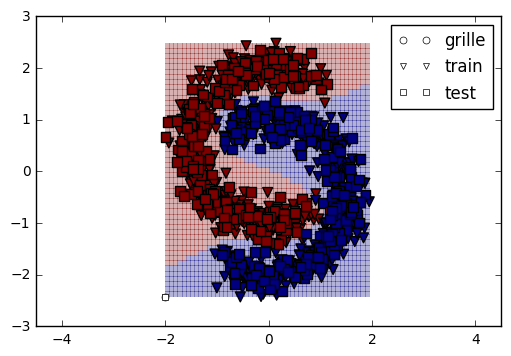

Valeur de lambdas trop élevée
hyperparamètres: 20 neurones cachés, lambdas à 0.1, taille de lot 100, learning rate 0.05, 1000 époques
le taux d erreur est : 51.6304347826 %
les régions de décisions sont:


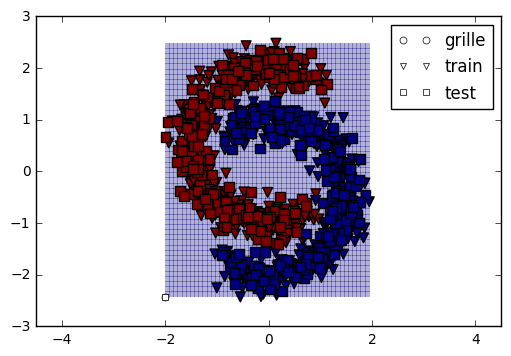

Taille de lot trop élevée pour learning rate trop faible
hyperparamètres: 20 neurones cachés, lambdas à 0.00001, taille de lot 200, learning rate 0.01, 1000 époques
le taux d erreur est : 3.53260869565 %
les régions de décisions sont:


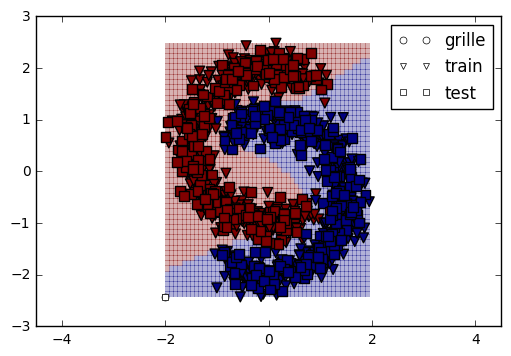

Nombre de neurones dans couche cachées trop élevé amenant à léger sur-apprentissage
hyperparamètres: 100 neurones cachés, lambdas à 0.00001, taille de lot 100, learning rate 0.05, 1000 époques


KeyboardInterrupt: 

In [18]:
print('Bonne combinaison d hyperparamètres')
print('hyperparamètres: 20 neurones cachés, lambdas à 0.00001, taille de lot 100, learning rate 0.05, 1000 époques')
lambdas = np.array([[0.0001, 0.0001],
       [0.0001, 0.0001]])
nn = NeuralNet_loop(2,20,2,lambdas, 100)   
nn.train(train_data,1000,0.05) 
print('le taux d erreur est :', taux_erreur(nn, validation_data),'%')
print('les régions de décisions sont:')
gridplot(nn, train_data, validation_data, 50)

print('Valeur de lambdas trop élevée')
print('hyperparamètres: 20 neurones cachés, lambdas à 0.1, taille de lot 100, learning rate 0.05, 1000 époques')
lambdas = np.array([[0.1, 0.1],
       [0.1, 0.1]])
nn = NeuralNet_loop(2,20,2,lambdas, 100)   
nn.train(train_data,1000,0.05) 
print('le taux d erreur est :', taux_erreur(nn, validation_data),'%')
print('les régions de décisions sont:')
gridplot(nn, train_data, validation_data, 50)

print('Taille de lot trop élevée pour learning rate trop faible')
print('hyperparamètres: 20 neurones cachés, lambdas à 0.00001, taille de lot 200, learning rate 0.01, 1000 époques')
lambdas = np.array([[0.0001, 0.0001],
       [0.0001, 0.0001]])
nn = NeuralNet_loop(2,20,2,lambdas, 100)   
nn.train(train_data,1000,0.01) 
print('le taux d erreur est :', taux_erreur(nn, validation_data),'%')
print('les régions de décisions sont:')
gridplot(nn, train_data, validation_data, 50)

print('Nombre de neurones dans couche cachées trop élevé amenant à léger sur-apprentissage')
print('hyperparamètres: 100 neurones cachés, lambdas à 0.00001, taille de lot 100, learning rate 0.05, 1000 époques')
lambdas = np.array([[0.0001, 0.0001],
       [0.0001, 0.0001]])
nn = NeuralNet_loop(2,100,2,lambdas, 100)   
nn.train(train_data,1000,0.05) 
print('le taux d erreur est :', taux_erreur(nn, validation_data),'%')
print('les régions de décisions sont:')
gridplot(nn, train_data, validation_data, 50)

print('Nombre d époques trop faible, arrêt trop prématuré de l apprentissage')
print('hyperparamètres: 100 neurones cachés, lambdas à 0.00001, taille de lot 100, learning rate 0.05, 50 époques')
lambdas = np.array([[0.0001, 0.0001],
       [0.0001, 0.0001]])
nn = NeuralNet_loop(2,100,2,lambdas, 100)   
nn.train(train_data,50,0.05) 
print('le taux d erreur est :', taux_erreur(nn, validation_data),'%')
print('les régions de décisions sont:')
gridplot(nn, train_data, validation_data, 50)

## 6. Implémentation du calcul de gradient avec expressions matricielles

Ici, on va représenter nos données par une matrice $\mathbf{X}$ de dimension $n \times d$  où chaque ligne de la matrice est un exemple $\mathbf{x}^{(i)}$. On définit une matrice $\mathbf{B}^{(1)}$ où chaque colonne est une copie du vecteur $\mathbf{b}^{(1)}$. On applique donc l'équation suivante pour calculer $\mathbf{h}^{a}$:

$\mathbf{W}^{(1)} \in \mathbb{R}^{d_h \times d}, \;\; \mathbf{X} \in \mathbb{R}^{n \times d} \;$ et $\;\mathbf{B}^{(1)} \in \mathbb{R}^{d_h \times n}$

$$\mathbf{h}^{a} = \mathbf{W}^{(1)}\mathbf{X}^{\top} + \mathbf{B}^{(1)} \in \mathbb{R}^{d_h \times n}$$

Remarquez qu'avec numpy nous n'avons pas besoin de recopier le vecteur $\mathbf{b}^{(1)}$ n fois. Nous pouvons simplement faire la somme de chaque colonnes de $\mathbf{X}$ avec le vecteur colonne $\mathbf{b}^{(1)}$:

```self.W1.dot(X.T) + self.b1.reshape(self.n_h, 1)```

Alors $\mathbf{h}^{a}$ sera une matrice de dimension $d_h \times n$ où chaque colonne $j$ est le vecteur de preactivation des neuronnes de la couche cachée pour le $j^{ieme}$ exemple. Ensuite, pour le calcul, $\mathbf{h}^s$ on applique la fonction relu$(\mathbf{h}^{a})$ qui retourne une matrice  de dimension $d_h \times n$ où la colonne $j$ est le vecteur de sortie des neuronnes de la couche cachée qui correspond au $j^{ieme}$ exemple d'entraînement.

Pour le calcule de $\mathbf{o}^a$, on applique le même principe:

$\mathbf{W}^{(2)} \in \mathbb{R}^{m \times d_h}, \;\; \mathbf{h}^{s} \in \mathbb{R}^{d_h \times n} \;$ et $\;\mathbf{B}^{(2)} \in \mathbb{R}^{m \times n}$

$$\mathbf{o}^{a} = \mathbf{W}^{(2)}\mathbf{h}^{s} + \mathbf{B}^{(2)} \in \mathbb{R}^{m \times n}$$
et,
$$\mathbf{o}^{s} = \text{softmax}(\mathbf{o}^{a}) \in \mathbb{R}^{m \times n}$$

où la colonne $j$ de $\mathbf{o}^a$ est le vecteur de preactivation de la couche cachee pour le $j^{ieme}$ exemple de notre ensemble d'entraînement. Pour la matrice $\mathbf{o}^{s}$, chaque colonne correspond au vecteur de sortie pour chaque exemple.

Pour le calcul des gradient, on a:
$$\mathbf{Y} \in \mathbb{R}^{n}$$ est un vecteur où chaque composante est la classes de l'exemple d'entraînement coresspondant. On redéfinit la fonction onehot pour l'appliquer sur le vecteur $\mathbf{Y}$. Cette nouvelle fonction va retourner une matrice ou chaque colonne est le vecteur onehot qui correspond chaque composante.

$$\nabla_{\mathbf{o}^a} = \mathbf{o}^s - \text{onehot}(\mathbf{Y}) \in \mathbb{R}^{m \times n}$$


$$\nabla_{\mathbf{B}^{(2)}} = \nabla_{\mathbf{o}^a} \in \mathbb{R}^{m \times n}$$


$$\sum_{\mathbf{W}^{(2)}} = \nabla_{\mathbf{W}^{(2)}} = \mathbf{W}^{(2)^{\top}} \nabla_{\mathbf{o}^a} \in \mathbb{R}^{m \times n}$$

Correspond a la sommes des gradients par rapport a $\mathbf{W}^{(2)}$ sur tout l'ensemble d'entraînement


$$\sum_{\mathbf{W}^{(1)}} = \nabla_{\mathbf{W}^{(1)}} = \mathbf{h}^{a} \mathbf{X} \in \mathbb{R}^{d_h \times n}$$


$$\nabla_{\mathbf{B}^{(1)}} = \nabla_{\mathbf{h}^a} \in \mathbb{R}^{d_h \times n}$$

In [19]:
class NeuralNetVectorized:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K=1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.lambdas = lambdas
        self.K = K
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        np.random.seed(123)
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, X):
        '''
        Computes activations for every layer
        X: input data set
        '''
        self.ha = self.W1.dot(X.T) + self.b1.reshape(self.n_h, 1)
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2.reshape(self.n_o, 1)
        self.os = np.transpose(softmax(self.oa.T))
            
    def bprop(self, X, Y):
        '''
        Computes the gradients, must be executed after fprop
        X: Input data set
        Y: targets
        '''
        n = X.shape[0]
                      
        grad_oa = self.os - onehot_matrix(self.n_o, Y)
        grad_b2 = np.sum(grad_oa, axis =1) # sum of b2 vectors on all training examples (m x 1)
        grad_W2 = np.dot(grad_oa, self.hs.T) # sum of gradients grad_W2 for each example
        grad_hs = self.W2.T.dot(grad_oa) # d_h x n
        grad_ha = grad_hs * (self.ha > 0) # d_h x n
        grad_W1 = np.dot(grad_ha, X) # sum of gradients grad_W1 for each example
        grad_b1 = np.sum(grad_ha, axis =1) # sum of b1 vectors on all training examples (d_h x 1)
        
        return grad_W1 / n, grad_W2 / n, grad_b1 / n, grad_b2 / n #returns average of the gradient
    
    def compute_loss(self, Y):
        loss = 0
        for i in range(Y.shape[0]):
            loss = loss -np.log(self.os[Y[i],i])
        return loss
    
    def train(self, train_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        for i in range(max_iter):
            for j in range(0,train_data.shape[0],self.K):
                batch = train_data[j:j+self.K]
                
                self.fprop(batch[:,:-1])
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean = self.bprop(batch[:,:-1], batch[:,-1]) 
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                    
    def compute_predictions(self, test_data):
        self.fprop(test_data)
        pred = self.os

        return pred



## 7. Comparaison du gradient des deux implémentations

In [20]:
#initialize a neural network of each implementation, with K=1 and K=10
for K in range(1,11,9):
    lambdas = np.array([[0, 0],
           [0, 0]])
    nn_loop = NeuralNet_loop(2,2,2,lambdas, K)
    nn_matrix = NeuralNetVectorized(2,2,2,lambdas,K)
    
    #gradient with loop implementation
    grad_W1_loop, grad_W2_loop, grad_b1_loop, grad_b2_loop, _ = nn_loop.bprop(train_data[:,:-1],train_data[:,-1])
    
    #gradient with matrix multiplications implementation
    nn_matrix.fprop(train_data[:,:-1])
    grad_W1_mat, grad_W2_mat, grad_b1_mat, grad_b2_mat = nn_matrix.bprop(train_data[:,:-1],train_data[:,-1])
    
    #print comparison of all gradients
    print('Différence entre les deux gradients pour W1, W2, b1, b2 lorsque la taille du lot est ', K)
    print(grad_W1_loop / grad_W1_mat)

    print(grad_W2_loop / grad_W2_mat)

    print(grad_b1_loop / grad_b1_mat)

    print(grad_b2_loop / grad_b2_mat)

Différence entre les deux gradients pour W1, W2, b1, b2 lorsque la taille du lot est  1
[[ 1.  1.]
 [ 1.  1.]]
[[ 1.  1.]
 [ 1.  1.]]
[ 1.  1.]
[ 1.  1.]
Différence entre les deux gradients pour W1, W2, b1, b2 lorsque la taille du lot est  10
[[ 1.  1.]
 [ 1.  1.]]
[[ 1.  1.]
 [ 1.  1.]]
[ 1.  1.]
[ 1.  1.]


On remaque que les parametre calculé par descente de gradient avec les deux modèles on un ratio de 1 (i.e.: ils sont egale)

## 8. Comparaison du temps de calcul pour une époque quand K=100

Fetch MNIST dataset

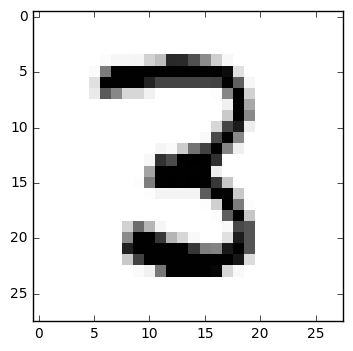

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('mnist-original')
#mnist = fetch_mldata('mnist-original', data_home='/u/dift3395/sklearn_data')

plt.imshow(mnist.data[21455,:].reshape(28, 28), interpolation="nearest", cmap='Greys')

Diviser le dataset MNIST en ensembles train, valid et test.

In [22]:
indices = np.random.permutation(len(mnist['target']))

print(mnist['data'].shape)

X_train = mnist['data'][indices][:50000]/255.
X_valid = mnist['data'][indices][50000:60000]/255.
X_test = mnist['data'][indices][60000:]/255.
y_train = mnist['target'][indices][:50000]
y_valid = mnist['target'][indices][50000:60000]
y_test = mnist['target'][indices][60000:]

#from keras.utils import np_utils
#y_train = np_utils.to_categorical(y_train)
#y_valid = np_utils.to_categorical(y_valid)
#y_test = np_utils.to_categorical(y_test)

#concatenate data and target into one np.array
train = np.concatenate((X_train, np.reshape(y_train, (50000,1))), axis=1)
valid = np.concatenate((X_valid, np.reshape(y_valid, (10000,1))), axis=1)
test = np.concatenate((X_test, np.reshape(y_test, (10000,1))), axis=1)

(70000, 784)


In [23]:
#initializing neural networks
nn_loop = NeuralNet_loop(784,20,10,lambdas,100)
nn_matrix = NeuralNetVectorized(784,20,10,lambdas,100)

#train both neural networks
import time
start_time = time.time()
nn_loop.train(train,1,0.05)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
nn_matrix.train(train,1,0.05)
print("--- %s seconds ---" % (time.time() - start_time))

--- 18.6254301071167 seconds ---
--- 1.6593289375305176 seconds ---


On voit que l'implementation avec le calcul matriciel du gradient est plus rapide par un facteur 10 que l'implementation avec boucle

## 9. Calcul de taux d'erreur de classification sur MNIST

Modification de la classe NeuralNetworkVectorized pour calculer les valeurs recherchées à chaque époque de la phase l'entraînement

In [30]:
class NeuralNetVectorized2:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K=1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.lambdas = lambdas
        self.K = K
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        np.random.seed(123)
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, X):
        '''
        Computes activations for every layer
        X: input data set
        '''
        self.ha = self.W1.dot(X.T) + self.b1.reshape(self.n_h, 1)
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2.reshape(self.n_o, 1)
        self.os = np.transpose(softmax(self.oa.T))
            
    def bprop(self, X, Y):
        '''
        Computes the gradients, must be executed after fprop
        X: Input data set
        Y: targets
        '''
        n = X.shape[0]
                      
        grad_oa = self.os - onehot_matrix(self.n_o, Y)
        grad_b2 = np.sum(grad_oa, axis =1) # m x n
        grad_W2 = np.dot(grad_oa, self.hs.T) # sum of gradients grad_W2 for each example
        grad_hs = self.W2.T.dot(grad_oa) # d_h x n
        grad_ha = grad_hs * (self.ha > 0) # d_h x n
        grad_W1 = np.dot(grad_ha, X) # sum of gradients grad_W1 for each example
        grad_b1 = np.sum(grad_ha, axis =1) # d_h x n
        
        return grad_W1 / n, grad_W2 / n, grad_b1 / n, grad_b2 / n #returns average of the gradient
    
    def compute_loss(self, Y):
        ind = [i for i in range(Y.shape[0])]
        loss = self.os[Y.astype(int),ind]
        return np.mean(-np.log(loss))
    
    def train(self, train_data, valid_data, test_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        for i in range(max_iter):
            for j in range(0,train_data.shape[0],self.K):
                batch = train_data[j:j+self.K]
                
                self.fprop(batch[:,:-1])
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean = self.bprop(batch[:,:-1], batch[:,-1]) 
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                    
            self.write_in_file(i,train_data, valid_data, test_data)
                    
    def compute_predictions(self, test_data):
        self.fprop(test_data)
        pred = self.os
        return pred
    
    def write_in_file(self,epoque,train_data,valid_data,test_data):
        train_prob = self.compute_predictions(train_data[:,:-1])
        train_classe_pred = np.argmax(train_prob, axis = 0)  
        valid_prob = self.compute_predictions(valid_data[:,:-1])
        valid_classe_pred = np.argmax(valid_prob, axis = 0)
        test_prob = self.compute_predictions(test_data[:,:-1])
        test_classe_pred = np.argmax(test_prob, axis = 0)
        classif_erreur_train = 100*float(sum(sum([train_classe_pred != train_data[:,-1]])))/train_data.shape[0]
        classif_erreur_valid = 100*float(sum(sum([valid_classe_pred != valid_data[:,-1]])))/valid_data.shape[0]
        classif_erreur_test = 100*float(sum(sum([test_classe_pred != test_data[:,-1]])))/test_data.shape[0]
        self.fprop(train_data[:,:-1])
        loss_train = self.compute_loss(train_data[:,-1])
        self.fprop(valid_data[:,:-1])
        loss_valid = self.compute_loss(valid_data[:,-1])
        self.fprop(test_data[:,:-1])
        loss_test = self.compute_loss(test_data[:,-1])
        
        # Enregistre dans le fichier les résultats a chaque epoque.
        # file : les résultat sont écrit de facon compréhensible
        # fileforgraph pour realiser les graphiques
        if epoque==0: # Ecrase le fichier s'il existe
            file=open("Question_9.txt","w")
            file_forgraph=open("Question_9_forgraph.txt","w")
        else: # ecrit en bas du fichier
            file = open("Question_9.txt", "a")
            file_forgraph=open("Question_9_forgraph.txt","a")
        toprint= 'Epoque %d,ERREUR - train : %f, valid : %f, test :%f,\
        COUT MOYEN train : %f, valid : %f, test: %f'\
        % (epoque+1,classif_erreur_train,classif_erreur_valid,classif_erreur_test,\
        loss_train, loss_valid, loss_test)
        
        toprint_forgraph  = '%d %f %f %f %f %f %f' % (epoque+1,classif_erreur_train,classif_erreur_valid,
                                                      classif_erreur_test,loss_train, loss_valid, loss_test)
        # Ecriture dans les fichiers
        file.write(toprint)
        file_forgraph.write(toprint_forgraph)
        
        file.close()
        file_forgraph.close()
        #Afficher les résultats pour la recherche des meilleur parametre
        print ('Epoque : %d Erreur sur le valid : %f' % (epoque+1,classif_erreur_valid))

## Question 10

In [33]:
lambdas = np.array([[0.0, 0.0],
                    [0.00, 0.00]])
nn_mnist = NeuralNetVectorized2(784,256,10,lambdas,50)
nn_mnist.train(train, valid, test, 20,eta=0.25)

Epoque : 1 Erreur sur le valid : 4.700000


KeyboardInterrupt: 

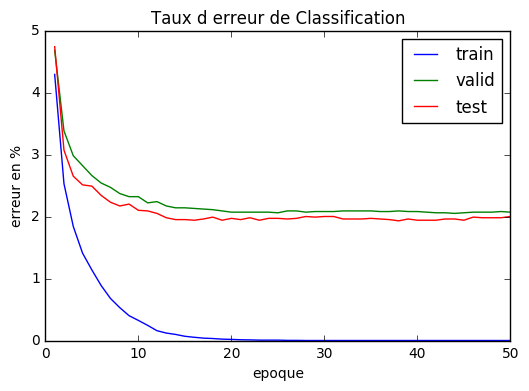

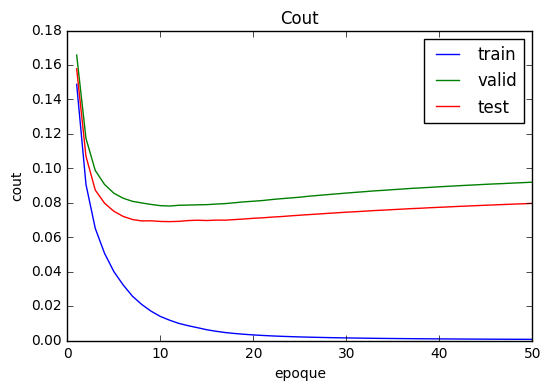

In [35]:
# Graphique de l'erreur de classification et du cout sur mnist a partir des 
import matplotlib.pyplot as plt
data=np.loadtxt(open('Question_9_forgraph.txt','r'))
epoque=data[:,0]
erreur_train=data[:,1]
erreur_valid=data[:,2]
erreur_test=data[:,3]
cout_train=data[:,4]
cout_valid=data[:,5]
cout_test=data[:,6]
plt.plot(epoque, erreur_train,label='train')
plt.plot(epoque, erreur_valid, label='valid')
plt.plot(epoque, erreur_test,label='test')
plt.legend()
plt.xlabel('epoque')
plt.ylabel('erreur en %')
plt.title('Taux d erreur de Classification')
plt.show()
plt.plot(epoque, cout_train,label='train')
plt.plot(epoque, cout_valid, label='valid')
plt.plot(epoque, cout_test,label='test')
plt.legend()
plt.xlabel('epoque')
plt.ylabel('cout')
plt.title('Cout')
plt.show()

Avec la meilleure configuration obtenue pour les hyperparametres (256 neurones dans la couche cachee, lambdas = 0, taille de lot = 50, learning rate = 0.25) voit que l erreur de classification de l ensemble de validation diminue beaucoup les 15 premieres epoques puis se stabilise un peu au dessus de 2%. Cela semble optimal d arreter l entrainement apres environ 20 epoques selon l erreur sur l ensemble de validation. L erreur sur l ensemble de test pour cette configuration des hyperparametres est legerement inferieure a celle de validation et est 1.97%. Mais il y a probablement un facteur aleatoire du a la selection random des indices des ensembles train, valid et test.